In [2]:
import pandas
import time
import spotipy
from pymongo import MongoClient
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
CLIENT_ID = "babe92be2a684de9929f827de4a0c406"
CLIENT_SECRET = "07492b49deae48f8956c9faf3d97cb84"
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
try:
    conn = MongoClient("mongodb://4.240.83.35:27017")
    print("Connected successfully!!!")
except:  
    print("Could not connect to MongoDB")

Connected successfully!!!


In [5]:
mydb = conn.spotify_db

In [6]:
# retrieving track data - track_id, track_name, track_popularity, artist_name, artist_id

track_list = []
for i in range(0,1000,50):
    track_results = sp.search(q='year:2022', type='track', limit=50,offset=i)
    time.sleep(0.5)
    # print(track_results['tracks']['items'])
    for i, t in enumerate(track_results['tracks']['items']):
        if t is None:
#             print(t)
            continue
        else:
            track = dict()
            track['track_id'] = t['id']
            track['track_name'] = t['name']
            track['track_popularity'] = t['popularity']
            track['artist_name'] = t['artists'][0]['name']
            track['artist_id'] = t['artists'][0]['id']
            track_list.append(track)

# to get the ids of each track specifically 
tracks = list()
for track_info in track_list:
    # print(track_info, end = '\n\n')
    tracks.append(track_info['track_id'])

print(len(tracks))

1000


In [7]:

# some tracks have None value and hence they are not subscriptable, hence we need to omit those tracks from the dataframe
# preprocessing step
tracks_info_preprocessed = []
indices_to_del = []
k = 0
for j in range(0, len(tracks), 100):
    tracks_info = sp.audio_features(tracks[j:j+100])
    for i in range(0, len(tracks_info)):
        if tracks_info[i] is None:
            # indices with track_info as None 
            indices_to_del.append(i+k)
            continue;
        else:
            new_track = tracks_info[i].copy()
            tracks_info_preprocessed.append(new_track)
    k = k+100

# remove tracks with ids that have None returned in the track_info
# indies = 61, 468, 801 - drop these rows
print(len(track_list))

for i in range(len(indices_to_del)):
    track_list.pop(indices_to_del[i])


print(len(track_list))        
print(len(tracks_info_preprocessed))


1000
997
997


In [8]:
track_info = tracks_info_preprocessed
for i in range(len(tracks_info_preprocessed)):
    track_list[i]['danceability'] = track_info[i]['danceability']
    track_list[i]['energy'] = track_info[i]['energy']
    track_list[i]['loudness'] = track_info[i]['loudness']
    track_list[i]['speechiness'] = track_info[i]['speechiness']
    track_list[i]['acousticness'] = track_info[i]['acousticness']
    track_list[i]['instrumentalness'] = track_info[i]['instrumentalness']
    track_list[i]['liveness'] = track_info[i]['liveness']
    track_list[i]['valence'] = track_info[i]['valence']
    track_list[i]['tempo'] = track_info[i]['tempo']
    track_list[i]['key'] = track_info[i]['key']
    track_list[i]['mode'] = track_info[i]['mode']
    track_list[i]['duration'] = track_info[i]['duration_ms']

In [9]:
track_collection = mydb["track_features"]

In [10]:
track_collection.insert_many(track_list)

In [1]:
artist_popularity = []
artist_genres = []
artist_followers = []
artist_id = []

artists_list = [None]*len(track_list)
artist_ids = []

for i in range(0, len(track_list)):
    artists_list[i] = track_list[i]['artist_id']
    

for val in set(artists_list):
    artist_ids.append(val)

for i in range(0, len(artist_ids), 50):
    if i+50>len(artist_ids):
        artists_data = sp.artists(artist_ids[i:])
        
    else:
        artists_data = sp.artists(artist_ids[i:i+50])

artists_list = []
for i in range(len(artists_data['artists'])):
    artist = dict()
    artist['id'] = artists_data['artists'][i]['id']
    artist['name'] = artists_data['artists'][i]['name']
    artist['popularity'] = artists_data['artists'][i]['popularity']
    artist['genres'] = artists_data['artists'][i]['genres']
    artist['followers'] = artists_data['artists'][i]['followers']['total']
    artists_list.append(artist)
print((artists_list))

In [2]:
artists_recc = []
for artist in artists_list:
    new_artist = dict()
    new_artist['id'] = artist['id']
    new_artist['name'] = artist['name']
    artists_recc.append(new_artist)

print(artists_recc)

In [3]:
track_recc= []
for track in track_list:
    new_track = dict()
    new_track['name'] = track['track_name']
    new_track['id'] = track['track_id']
    track_recc.append(new_track)
print(track_recc)

In [13]:
artist_collection = mydb["artists"]

In [14]:
artist_collection.insert_many(artists_list)

In [15]:
#select database
db = conn['spotify_db']
#select the collection within the database
cursor = db.artists
#convert entire collection to Pandas dataframe
artists_df = pandas.DataFrame(list(cursor.find()))
artists_df.rename(columns = {'id':'artist_id'}, inplace = True)
artists_df.head()

,_id,artist_id,name,popularity,genres,followers
0,6440c940eebfbf43939a576c,2oQX8QiMXOyuqbcZEFsZfm,El Alfa,78,"[dembow, rap dominicano, reggaeton, trap latin...",2813728
1,6440c940eebfbf43939a576d,4UrIphY7uGLwD0rRd6NIi9,Lambo4oe,63,[],11403
2,6440c940eebfbf43939a576e,5IH6FPUwQTxPSXurCrcIov,Alec Benjamin,77,"[alt z, pop]",4262196
3,6440c940eebfbf43939a576f,0avMDS4HyoCEP6RqZJWpY2,Ethel Cain,63,"[indie pop, modern dream pop]",214762
4,6440c940eebfbf43939a5770,6JoYL9QYbdgPb6EuE5J2pC,Gerardo Coronel,71,"[banda, corrido, musica mexicana, norteno, nue...",916818


In [16]:
##EDA

In [17]:
artists_df.describe()

,popularity,followers
count,25.000000,2.500000e+01
mean,68.160000,2.159844e+06
std,10.270021,6.389952e+06
min,51.000000,7.600000e+01
25%,60.000000,9.965800e+04
50%,69.000000,3.941760e+05
75%,73.000000,1.576095e+06
max,88.000000,3.233403e+07


In [18]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         25 non-null     object
 1   artist_id   25 non-null     object
 2   name        25 non-null     object
 3   popularity  25 non-null     int64 
 4   genres      25 non-null     object
 5   followers   25 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 1.3+ KB


In [5]:
cursor = db.track_features
track_features_df = pandas.DataFrame(list(cursor.find()))
track_features_df.head()

In [20]:
track_features_df.describe()

,track_popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,duration
count,997.00000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000
mean,76.28987,0.658619,0.609668,-7.209800,0.116825,0.261144,0.040908,0.180306,0.482339,124.115408,5.231695,0.657974,185706.801404
std,6.63894,0.157658,0.188716,4.336594,0.114820,0.267290,0.169019,0.130540,0.242941,29.132245,3.617155,0.474626,45640.940609
min,65.00000,0.068500,0.001850,-38.664000,0.023100,0.000018,0.000000,0.022200,0.000010,51.660000,0.000000,0.000000,47354.000000
25%,71.00000,0.561000,0.491000,-8.285000,0.039800,0.042500,0.000000,0.101000,0.284000,100.009000,2.000000,0.000000,160007.000000
50%,76.00000,0.674000,0.624000,-6.459000,0.064600,0.159000,0.000000,0.128000,0.472000,123.351000,5.000000,1.000000,182453.000000
75%,81.00000,0.773000,0.748000,-4.866000,0.154000,0.425000,0.000092,0.218000,0.677000,144.981000,8.000000,1.000000,210685.000000
max,97.00000,0.984000,0.996000,-0.514000,0.782000,0.996000,0.971000,0.940000,0.973000,203.803000,11.000000,1.000000,524757.000000


In [21]:
track_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               997 non-null    object 
 1   track_id          997 non-null    object 
 2   track_name        997 non-null    object 
 3   track_popularity  997 non-null    int64  
 4   artist_name       997 non-null    object 
 5   artist_id         997 non-null    object 
 6   danceability      997 non-null    float64
 7   energy            997 non-null    float64
 8   loudness          997 non-null    float64
 9   speechiness       997 non-null    float64
 10  acousticness      997 non-null    float64
 11  instrumentalness  997 non-null    float64
 12  liveness          997 non-null    float64
 13  valence           997 non-null    float64
 14  tempo             997 non-null    float64
 15  key               997 non-null    int64  
 16  mode              997 non-null    int64  
 1

In [22]:
# top 20 most popular tracks of 2022
df = track_features_df.sort_values(by=['track_popularity'], ascending=False)[['track_name', 'artist_name']].head(20)
df.reset_index(drop=True, inplace=True)
df

,track_name,artist_name
0,Creepin' (with The Weeknd & 21 Savage),Metro Boomin
1,Calm Down (with Selena Gomez),Rema
2,Kill Bill,SZA
3,I'm Good (Blue),David Guetta
4,Anti-Hero,Taylor Swift
5,Here With Me,d4vd
6,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap
7,I Ain't Worried,OneRepublic
8,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez
9,AMG,Natanael Cano


In [23]:
#tracks with popularity greater than 90%
most_popular = track_features_df.query('track_popularity>90', inplace = False).sort_values('track_popularity', ascending = False)
most_popular[:10]

,_id,track_id,track_name,track_popularity,artist_name,artist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,duration
1,6440c928eebfbf43939a5388,2dHHgzDwk4BJdRwy9uXhTO,Creepin' (with The Weeknd & 21 Savage),97,Metro Boomin,0iEtIxbK0KxaSlF7G42ZOp,0.715,0.620,-6.005,0.0484,0.41700,0.000000,0.0822,0.172,97.950,1,0,221520
12,6440c928eebfbf43939a5393,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),96,Rema,46pWGuE3dSwY3bMMXGBvVS,0.801,0.806,-5.206,0.0381,0.38200,0.000669,0.1140,0.802,106.999,11,1,239318
0,6440c928eebfbf43939a5387,1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,95,SZA,7tYKF4w9nC0nq9CsPZTHyP,0.644,0.735,-5.747,0.0391,0.05210,0.144000,0.1610,0.418,88.980,8,1,153947
6,6440c928eebfbf43939a538d,0V3wPSX9ygBnCm8psDIegu,Anti-Hero,95,Taylor Swift,06HL4z0CvFAxyc27GXpf02,0.637,0.643,-6.571,0.0519,0.13000,0.000002,0.1420,0.533,97.008,4,1,200690
16,6440c928eebfbf43939a5397,78Sw5GDo6AlGwTwanjXbGh,Here With Me,95,d4vd,5y8tKLUfMvliMe8IKamR32,0.574,0.469,-8.209,0.0254,0.53400,0.000092,0.1280,0.288,132.023,4,1,242485
26,6440c928eebfbf43939a53a1,4uUG5RXrOk84mYEfFvj3cK,I'm Good (Blue),95,David Guetta,1Cs0zKBU1kc0i8ypK3B9ai,0.561,0.965,-3.673,0.0343,0.00383,0.000007,0.3710,0.304,128.040,7,0,175238
94,6440c928eebfbf43939a53e5,2tTmW7RDtMQtBk7m2rYeSw,"Quevedo: Bzrp Music Sessions, Vol. 52",94,Bizarrap,716NhGYqD1jl2wI1Qkgq36,0.621,0.782,-5.548,0.0440,0.01250,0.033000,0.2300,0.550,128.033,2,1,198938
13,6440c928eebfbf43939a5394,1lRtH4FszTrwwlK5gTSbXO,AMG,94,Natanael Cano,0elWFr7TW8piilVRYJUe4P,0.772,0.730,-6.657,0.0972,0.15200,0.000107,0.2740,0.786,136.175,11,0,174943
21,6440c928eebfbf43939a539c,4h9wh7iOZ0GGn8QVp4RAOB,I Ain't Worried,94,OneRepublic,5Pwc4xIPtQLFEnJriah9YJ,0.704,0.797,-5.927,0.0475,0.08260,0.000745,0.0546,0.825,139.994,0,1,148486
24,6440c928eebfbf43939a539f,1Y3LN4zO1Edc2EluIoSPJN,Until I Found You (with Em Beihold) - Em Beiho...,94,Stephen Sanchez,5XKFrudbV4IiuE5WuTPRmT,0.551,0.550,-5.339,0.0286,0.77700,0.000000,0.2020,0.342,101.190,10,1,176440


In [129]:
# Least popular songs of 2022
df = track_features_df.sort_values(by=['track_popularity'], ascending=True)[['track_name', 'artist_name', 'track_popularity']].head(20)
df.reset_index(drop=True, inplace=True)
df

,track_name,artist_name
0,MJ (feat. Quezz Ruthless),Big Scarr
1,Backends,RiskTakerLeek
2,Poems and Closing Time,Zach Bryan
3,Ballin,Mike Sherm
4,Twist Made Me,Lil Wayne
5,Mountain Song,Flatland Cavalry
6,Thats How,Young Dolph
7,Rap Niggas,BigXthaPlug
8,Manute Bol,BabyTron
9,Starved,Zach Bryan


In [24]:
# most followed artists
by_art_fol = pandas.DataFrame(artists_df.sort_values(by=['followers'], ascending=False)[['name','popularity', 'followers','genres']])
by_art_fol.reset_index(drop=True, inplace=True)
by_art_fol.astype(str).drop_duplicates().head(20)

,name,popularity,followers,genres
0,Daddy Yankee,88,32334026,"['latin hip hop', 'reggaeton', 'trap latino', ..."
1,Alec Benjamin,77,4262196,"['alt z', 'pop']"
2,Fuerza Regida,87,2958011,"['corrido', 'corridos tumbados', 'norteno', 'n..."
3,El Alfa,78,2813728,"['dembow', 'rap dominicano', 'reggaeton', 'tra..."
4,Elevation Worship,73,2304239,"['ccm', 'christian music', 'world worship', 'w..."
5,Yeat,85,2241493,['pluggnb']
6,Yung Gravy,71,1576095,"['meme rap', 'minnesota hip hop']"
7,Gerardo Coronel,71,916818,"['banda', 'corrido', 'musica mexicana', 'norte..."
8,Lauren Spencer Smith,70,893970,"['alt z', 'gen z singer-songwriter']"
9,Jordan Davis,75,875508,"['contemporary country', 'country road']"


In [4]:
df_combined = pandas.concat([artists_df, track_features_df], axis = 1)
df_combined

In [26]:
df_combined=df_combined[df_combined['genres'].notnull()]

In [6]:
# how many songs of each genre are present 
def to_1D(series):
 return pandas.Series([x for _list in series for x in _list])
to_1D(df_combined['genres']).value_counts().head(100)

<AxesSubplot:xlabel='genres', ylabel='count'>

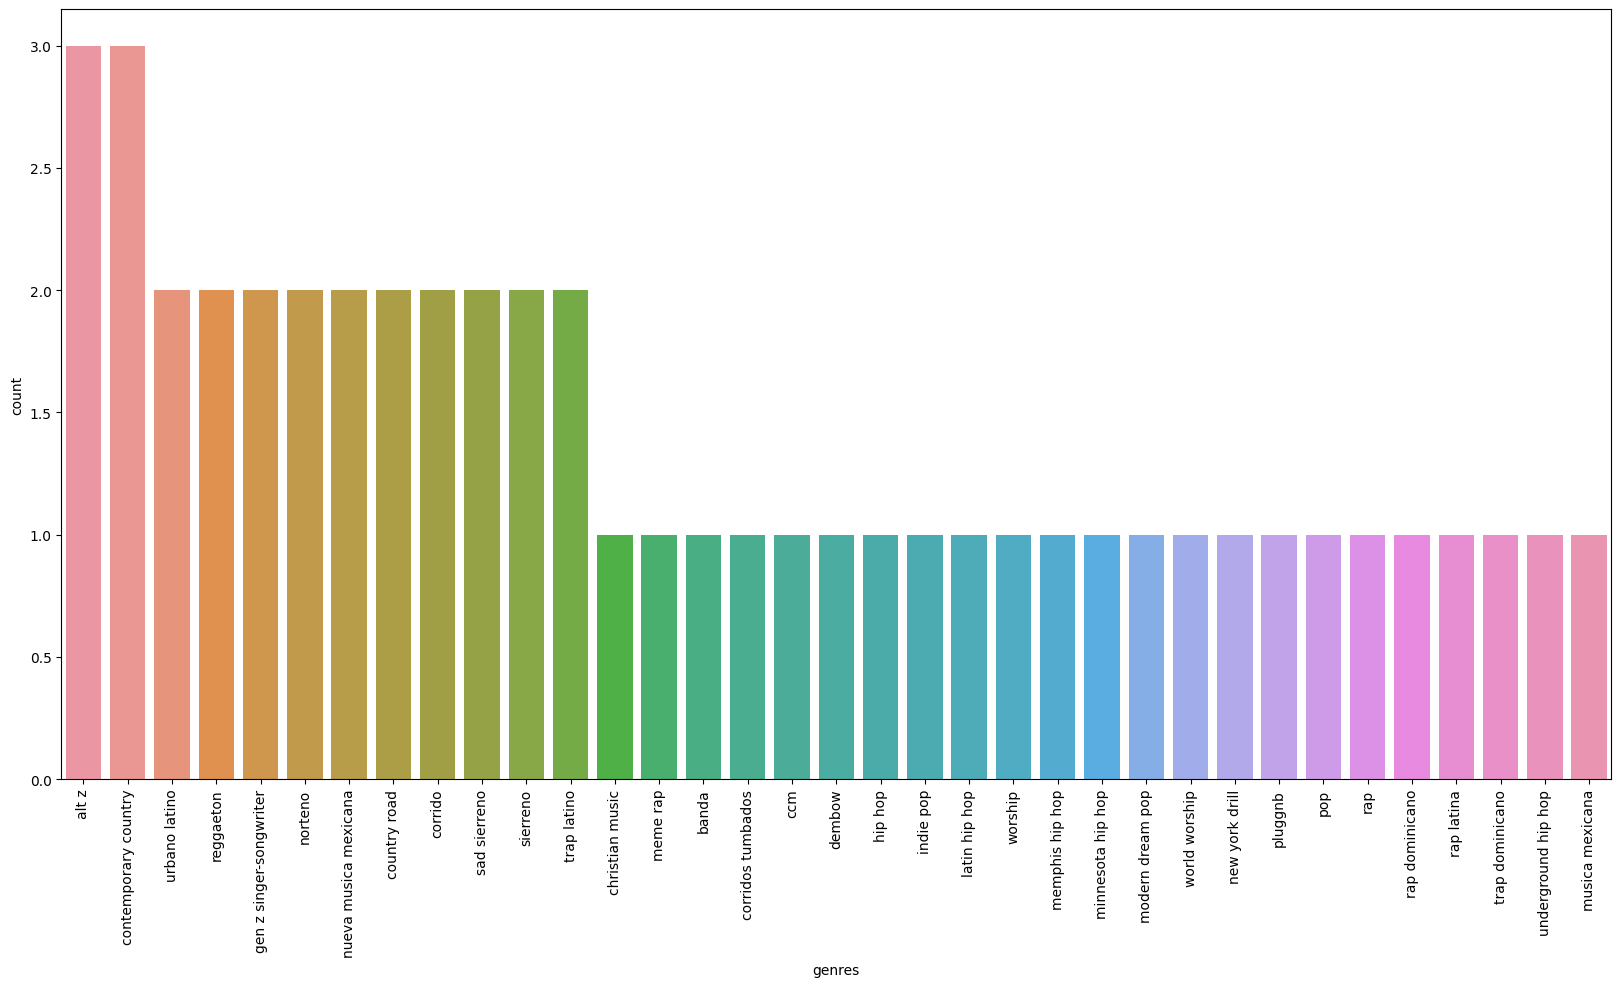

In [27]:
def to_1D(series):
    return pandas.Series([x for _list in series for x in _list])
temp=pandas.DataFrame((to_1D(df_combined['genres']).sort_values(ascending=False)), columns=['genres'])
temp

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.countplot(data=temp,x='genres', order = temp['genres'].value_counts().index)

In [7]:
## Top 20 artists sorted by the number of followers for each of top 10 genres:
top_10_genres = list(to_1D(df_combined['genres']).value_counts().index[:20])
top_artists_by_genre = []
for genre in top_10_genres:
  for index, row in by_art_fol.iterrows():
    if genre in row['genres']:
      top_artists_by_genre.append({'artist_name':row['name'], 'artist_genre':genre})
      break
pandas.json_normalize(top_artists_by_genre)

In [8]:
## Find top tracks sorted by popularity for each of top 20 genres:
by_track_pop = pandas.DataFrame(df_combined.sort_values(by=['track_popularity'], ascending=False)[['track_popularity','track_name', 'name','genres', 'track_id']])
by_track_pop.astype(str).drop_duplicates().head(20)
top_songs_by_genre = []
for genre in top_10_genres:
  for index, row in by_track_pop.iterrows():
    if genre in row['genres']:
      top_songs_by_genre.append({'track_name':row['track_name'], 'track_popularity':row['track_popularity'],'artist_name':row['name'], 'artist_genre':genre})
      break
pandas.json_normalize(top_songs_by_genre)

In [30]:
processed_track_features_df = track_features_df.drop(['key', 'mode', '_id', 'track_id', 'track_name', 'artist_name', 'artist_id'], axis = 1)
processed_track_features_df

,track_popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
0,95,0.644,0.735,-5.747,0.0391,0.05210,0.144000,0.1610,0.4180,88.980,153947
1,97,0.715,0.620,-6.005,0.0484,0.41700,0.000000,0.0822,0.1720,97.950,221520
2,91,0.486,0.545,-7.924,0.0336,0.06520,0.004740,0.0642,0.0385,150.187,123891
3,92,0.561,0.520,-9.342,0.2440,0.05030,0.000002,0.3550,0.4240,153.150,239360
4,91,0.526,0.606,-5.300,0.2590,0.15200,0.000002,0.1940,0.4920,116.622,182667
...,...,...,...,...,...,...,...,...,...,...,...
992,66,0.922,0.858,-4.185,0.2510,0.00451,0.000000,0.1240,0.9150,145.033,201979
993,73,0.688,0.637,-4.850,0.0310,0.00777,0.000000,0.1300,0.4270,129.902,184248
994,78,0.720,0.679,-5.385,0.0360,0.00693,0.846000,0.1000,0.2900,105.005,164577
995,69,0.727,0.530,-8.616,0.3120,0.28300,0.000028,0.3920,0.2580,174.025,210841


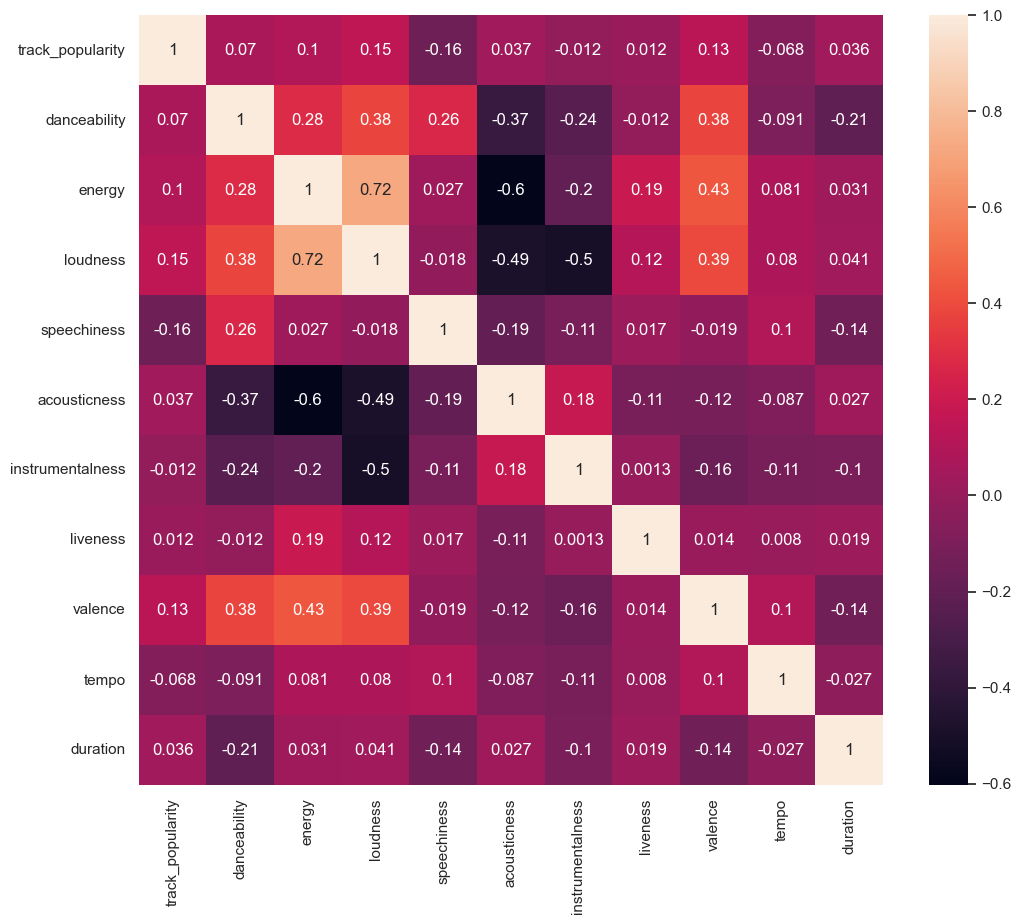

In [31]:
import seaborn as sn
sn.set(rc = {'figure.figsize':(12,10)})
sn.heatmap(processed_track_features_df.corr(), annot=True)
plt.show()

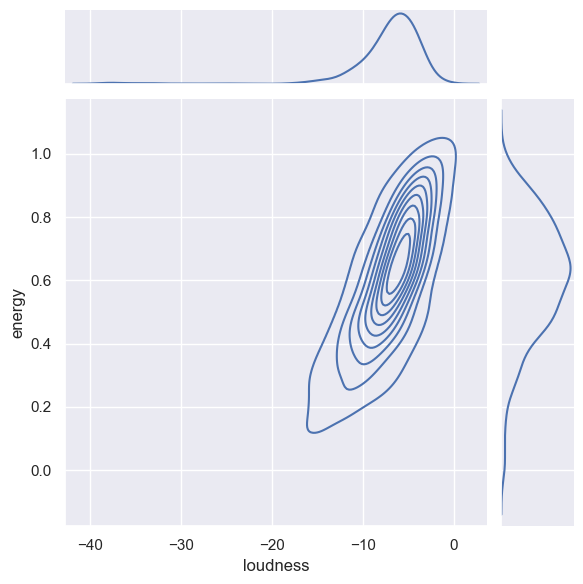

In [33]:
## Bivariate KDE for specific pair of variables 
sn.set(rc = {'figure.figsize':(20,20)})
sn.jointplot(data=processed_track_features_df, x="loudness", y="energy", kind="kde")

<AxesSubplot:xlabel='energy', ylabel='loudness'>

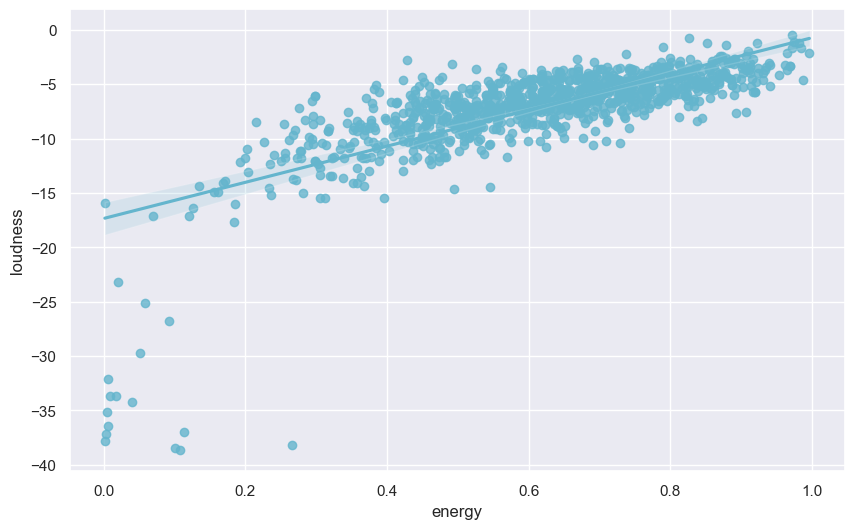

In [34]:
plt.figure(figsize = [10, 6])
sns.regplot(data = track_features_df, y = 'loudness', x = 'energy', color = 'c')

<AxesSubplot:xlabel='danceability', ylabel='track_popularity'>

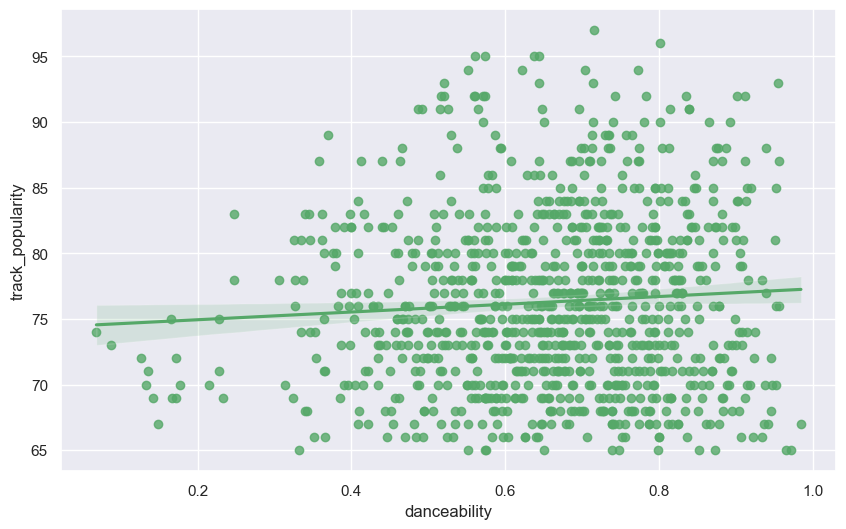

In [35]:
plt.figure(figsize = [10, 6])
sns.regplot(data = track_features_df, y = 'track_popularity', x = 'danceability', color = 'g')

In [9]:
import warnings
warnings.filterwarnings('ignore')

feat_cols = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

# sort based on track popularity to get top 50 most popular songs
most_popular = track_features_df.sort_values('track_popularity', ascending = False)[:100]
most_popular.reset_index(drop=True, inplace=True)
most_popular

from sklearn import preprocessing
mean_vals = pandas.DataFrame(columns=feat_cols)
mean_vals = mean_vals.append(most_popular.mean(), ignore_index=True)
mean_vals = mean_vals.append(processed_track_features_df[feat_cols].mean(), ignore_index=True)
print(mean_vals)

import plotly.graph_objects as go
import plotly.offline as pyo
fig = go.Figure(
    data=[
        go.Scatterpolar(r=mean_vals.iloc[0], theta=feat_cols, fill='toself', name='Top 100'),
        go.Scatterpolar(r=mean_vals.iloc[1], theta=feat_cols, fill='toself', name='All'),
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Feature comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

fig.show()

In [44]:
## Recommendation 
artist = dict()
track = dict()

for dictionary in artists_recc:
    key = ''
    value = ''
    for i in range(0, len(dictionary)):
        if i == 0:
            value = dictionary['id']
        else:
            key = dictionary['name']
    artist[key] = value

for dictionary in track_recc:
    key = ''
    value = ''
    for i in range(0, len(dictionary)):
        if i == 0:
            key = dictionary['name']
        else:
            value = dictionary['id']
    track[key] = value 

rec = sp.recommendations(seed_artists=[artist['Lainey Wilson']], seed_genres=["pop"], seed_tracks=[track["One Thing At A Time"]], limit=25)

for track in rec['tracks']:
  print(track['artists'][0]['name'], track['name'])

Morgan Wallen Redneck Love Song
AJR Weak
Eric Church Hell Of A View
Lorde Perfect Places
Megan Moroney Fix You Too
Hailey Whitters Raised
DJ Snake You Know You Like It
Morgan Wallen Bandaid On A Bullet Hole
G-Eazy Good Life (with G-Eazy & Kehlani)
French Montana No Shopping
Juice WRLD Lucid Dreams
Cole Swindell Break Up in the End
Corey Kent Same Heart Different Break - worktape
blackbear idfc
Randy Houser Rub A Little Dirt On It
The Weeknd I Feel It Coming
Randall King Can't You Feel How That Sounds
Morgan Wade Last Cigarette
Jordan Davis Lose You
Kiiara Whippin (feat. Felix Snow)
Passenger Let Her Go
Cheat Codes Only You (with Little Mix)
Cody Johnson On My Way to You
Lainey Wilson Heart Like A Truck
Morgan Wallen Little Rain


In [45]:
#### MODEL 
# regression model - predict popularity using a few parameters
from sklearn import linear_model

In [46]:
df_1 = track_features_df.iloc[:800]
df_2 = track_features_df.iloc[801:]

In [47]:
reg = linear_model.LinearRegression()
reg.fit(df_1[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']], df_1.track_popularity)

LinearRegression()

In [48]:
reg.coef_

array([ 6.03558967,  3.67626611, -7.87280269,  3.14153375,  1.97698464,
        1.48801513,  1.02454517])

In [49]:
reg.intercept_


70.66332098020085

In [10]:
# reg.predict([[ 0.852, 0.789, 0.423, 0.325, 0.250, 0.698, 0.741]])
reg.predict(df_2[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']])

In [51]:
reg.score(df_2[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']], df_2[['track_popularity']])

-2.0692799979670986